In [1]:
%%bash
# These files appear to be from the original competition (that is unmodified)
wget -q -c https://raw.githubusercontent.com/yasminlucero/Kaggle/master/Data/compDataAsSQLiteDB/compData.db
wget -q -c https://raw.githubusercontent.com/yasminlucero/Kaggle/master/Data/compDataAsSQLiteDB/compData.sql

In [ ]:
%matplotlib inline
import seaborn as sns

import sqlite3
import pandas as pd
import numpy as np

from patsy import dmatrices

from contextlib import closing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [11]:
seed = 13431
np.random.seed(seed)

with closing(sqlite3.connect('file:compData.db?mode=ro', uri=True)) as conn:    
    patientTranscripts = pd.read_sql_query("""
    SELECT PatientGuid,
        dmIndicator,
        Gender,
        YearOfBirth,
        VisitYear,
        CASE WHEN BMI = 0 THEN NULL ELSE BMI END AS BMI,
        CASE WHEN SystolicBP = 'NULL' THEN NULL ELSE SystolicBP END AS SystolicBP,
        CASE WHEN DiastolicBP = 'NULL' THEN NULL ELSE DiastolicBP END AS DiastolicBP
    FROM training_patientTranscript
""", conn)
  
    patientIcd9Codes = pd.read_sql_query("""
SELECT PatientGuid, ICD9Code
FROM training_diagnosis 
""", conn)
    
    # Note: Need to use training_patientSmokingStatus directly rather than patient_smoking
    # as the NIST codes used translate to multiple statuses
    patientSmokingStatus = pd.read_sql_query("""
SELECT PatientGuid, 
    EffectiveYear,
    SmokingStatusGuid
FROM training_patientSmokingStatus
""", conn)
    
    preDbMatch = pd.read_sql_query("""
SELECT DISTINCT PatientGuid
FROM training_diagnosis 
WHERE ICD9Code IN ('790.29','648.83')
""", conn)

In [71]:
# https://www.cdc.gov/healthyweight/assessing/index.html
def translateBMI(bmi):
    if bmi <  18.5:
        return "Underweight"
    elif 18.5 <= bmi <= 24.9:
        return  "Normal"
    elif 25 <= bmi <= 29.9:
        return "Overweight"
    else:
        return "Obese"
        
# https://www.heart.org/HEARTORG/Conditions/HighBloodPressure/KnowYourNumbers/Understanding-Blood-Pressure-Readings_UCM_301764_Article.jsp
def translateBP(systolicBP, diastolicBP):
    if systolicBP < 120 and diastolicBP < 80:
        return "Normal"
    elif systolicBP <= 129 and diastolicBP < 80:
        return "Elevated"
    elif systolicBP <= 139 or 80 <= diastolicBP <= 89:
        return "HTN_S1"
    elif 140 <= systolicBP or 90 <= diastolicBP:
        return "HTN_S2"
    else:
        return "Hypertensive_Crisis"

def calcAge(yearOfBirth):
    return 2012 - yearOfBirth

def isPreDB(patientGuid):
   return patientGuid in preDbMatch.PatientGuid.values
 
def isSmoker(ps, patientGuid):
    return patientGuid in ps.index and ps.loc[patientGuid, 'SmokingStatusGuid'] in ('FA2B7AE4-4D14-4768-A8C7-55B5F0CDF4AF', 
                                                                                    '02116D5A-F26C-4A48-9A11-75AC21BC4FD3', \
                                                                                    'DD01E545-D7AF-4F00-B248-9FD40010D81D', \
                                                                                    'FCD437AA-0451-4D8A-9396-B6F19D8B25E8', \
                                                                                    '2548BD83-03AE-4287-A578-FA170F39E32F')

def processPatientTranscripts(pt):
    pt = pt.sort_values(['VisitYear'],  ascending=False)
    pt = pt.groupby('PatientGuid', as_index=False).agg(lambda x: np.nan if x.first_valid_index() is None else x.loc[x.first_valid_index()])

    pt['dmIndicator'] = pt['dmIndicator'].astype('bool')
    pt['Gender'] = pt['Gender'].astype('category')
    pt['Age'] = pt.apply(lambda row: calcAge(row.YearOfBirth), axis=1)
    pt['PreDB'] = pt.apply(lambda row: isPreDB(row.PatientGuid), axis=1)
    
    pt['BMICategory'] = pt.apply(lambda row: translateBMI(row.BMI), axis=1).astype('category')
    pt['BPCategory'] = pt.apply(lambda row: translateBP(row.SystolicBP, row.DiastolicBP), axis=1).astype('category')
    
    pt.drop(['VisitYear', 'YearOfBirth', 'BMI', 'SystolicBP', 'DiastolicBP'], axis=1, inplace=True)
    pt.dropna(how='any', inplace=True)
    
    #pt['SystolicBP'] = pt['SystolicBP'].astype('int')
    #pt['DiastolicBP'] = pt['DiastolicBP'].astype('int')
    
    return pt

def processPatientSmoking(ps):
    ps = ps.sort_values(['EffectiveYear'], ascending=False)
    ps = ps.groupby('PatientGuid').agg(lambda x: np.nan if x.first_valid_index() is None else x.loc[x.first_valid_index()])
    
    ps['Smoker'] = ps.apply(lambda row: isSmoker(ps, row.name), axis=1)
    
    ps.drop(['EffectiveYear', 'SmokingStatusGuid'], axis=1, inplace=True)
    ps.dropna(how='any', inplace=True)
    ps.reset_index(level=0, inplace=True)

    return ps


In [72]:
transcripts = processPatientTranscripts(patientTranscripts)
transcripts.head()

,PatientGuid,dmIndicator,Gender,Age,PreDB,BMICategory,BPCategory
0,00023761-9D8D-445B-874C-2424CC7CF620,False,M,56,False,Overweight,Elevated
1,0005D9BD-0247-4F02-B7EE-7C1B44825FA1,False,F,60,False,Normal,HTN_S1
2,000B4862-7CE7-4EC5-8043-A97FCD74BD78,False,F,87,False,Underweight,Normal
3,00110ABC-DAB9-49E3-A1C8-88BBF8D58109,False,M,42,False,Overweight,Elevated
4,002667F4-B9A3-4DE2-875F-8034DD637865,False,F,84,False,Normal,HTN_S1


In [64]:
smokingStatus = processPatientSmoking(patientSmokingStatus)
smokingStatus.head()

,PatientGuid,Smoker
0,000B4862-7CE7-4EC5-8043-A97FCD74BD78,False
1,0029BBC8-7C22-4444-9F44-87BEF05FE033,False
2,003CEE1F-5BF5-4171-9284-F5464EC12D41,False
3,005F61C9-E537-4AD2-B39C-37F25891F33A,False
4,0063B34F-C2C4-423A-A144-E51F7149253A,False


In [73]:
patients = pd.merge(transcripts, smokingStatus, on='PatientGuid', how='left')
patients.fillna(False, inplace=True)
patients.drop(['PatientGuid'], axis=1, inplace=True)
patients.head()

,dmIndicator,Gender,Age,PreDB,BMICategory,BPCategory,Smoker
0,False,M,56,False,Overweight,Elevated,False
1,False,F,60,False,Normal,HTN_S1,False
2,False,F,87,False,Underweight,Normal,False
3,False,M,42,False,Overweight,Elevated,False
4,False,F,84,False,Normal,HTN_S1,False


In [74]:
# create dataframes with an intercept column and dummy variables for
# occupation and occupation_husb
y, X = dmatrices('dmIndicator ~ C(Gender) + C(BMICategory) + C(BPCategory) + Age + PreDB + Smoker',
                  patients, return_type="dataframe")
print(X.columns)

Index(['Intercept', 'C(Gender)[T.M]', 'C(BMICategory)[T.Obese]',
       'C(BMICategory)[T.Overweight]', 'C(BMICategory)[T.Underweight]',
       'C(BPCategory)[T.HTN_S1]', 'C(BPCategory)[T.HTN_S2]',
       'C(BPCategory)[T.Hypertensive_Crisis]', 'C(BPCategory)[T.Normal]',
       'PreDB[T.True]', 'Smoker[T.True]', 'Age'],
      dtype='object')


In [75]:
y = y.iloc[:, 1].astype('bool')

In [87]:
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.80749899477281861

In [50]:
y.mean()

0.19141449683321604

In [77]:
pd.DataFrame(list(zip(X.columns, np.transpose(model.coef_))))

,0,1
0,Intercept,[-2.56887956807]
1,C(Gender)[T.M],[0.314407155336]
2,C(BMICategory)[T.Obese],[1.23689555874]
3,C(BMICategory)[T.Overweight],[0.59413920651]
4,C(BMICategory)[T.Underweight],[-0.587308488861]
5,C(BPCategory)[T.HTN_S1],[0.0825752818868]
6,C(BPCategory)[T.HTN_S2],[0.247437982128]
7,C(BPCategory)[T.Hypertensive_Crisis],[-0.055363929218]
8,C(BPCategory)[T.Normal],[-0.0464614393761]
9,PreDB[T.True],[0.539522108099]


In [53]:
train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=seed)

In [54]:
lr = LogisticRegression()
lr.fit(train_X, train_y)

print("Accuracy = {:.2f}".format(lr.score(test_X, test_y)))

Accuracy = 0.81


In [55]:
# predict class labels for the test set
predicted = model.predict(test_X)
#print(predicted)
# generate class probabilities
probs = model.predict_proba(test_X)
#print(probs)

print(metrics.accuracy_score(test_y, predicted))
print(metrics.roc_auc_score(test_y, probs[:, 1]))

0.807035175879
0.713352267546


In [56]:
print(metrics.confusion_matrix(test_y, predicted))
print(metrics.classification_report(test_y, predicted))

[[1595   22]
 [ 362   11]]
             precision    recall  f1-score   support

      False       0.82      0.99      0.89      1617
       True       0.33      0.03      0.05       373

avg / total       0.72      0.81      0.74      1990



In [57]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(scores)
print(scores.mean())

[ 0.80421687  0.8002008   0.812249    0.80502513  0.80684105  0.80684105
  0.80382294  0.79577465  0.80885312  0.80985915]
0.805368374401


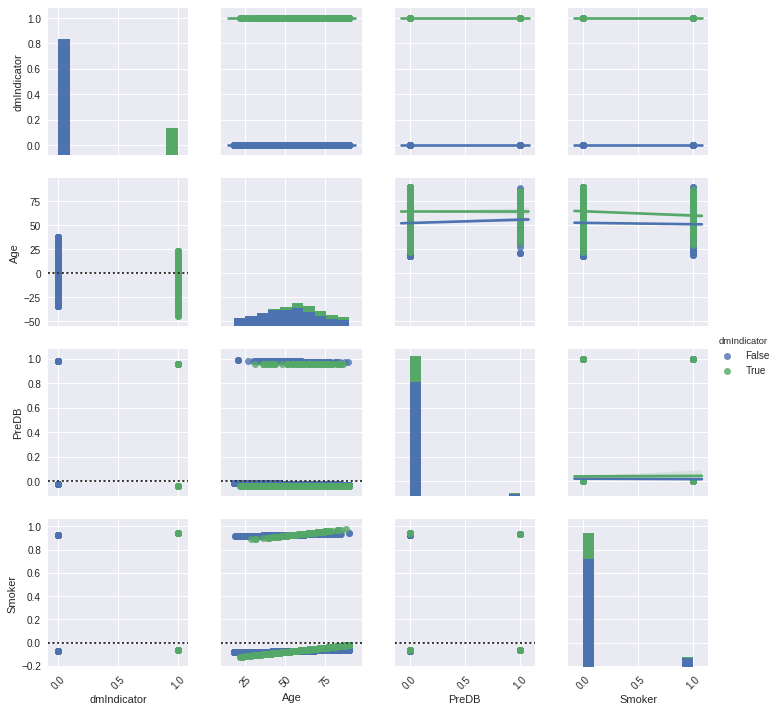

In [83]:
# import matplotlib.pyplot as plt

# g = sns.PairGrid(patients, hue="dmIndicator") 
# g.map_upper(sns.regplot) 
# g.map_lower(sns.residplot) 
# g.map_diag(plt.hist) 
# for ax in g.axes.flat: 
#     plt.setp(ax.get_xticklabels(), rotation=45) 
# g.add_legend() 
# g.set(alpha=0.5)

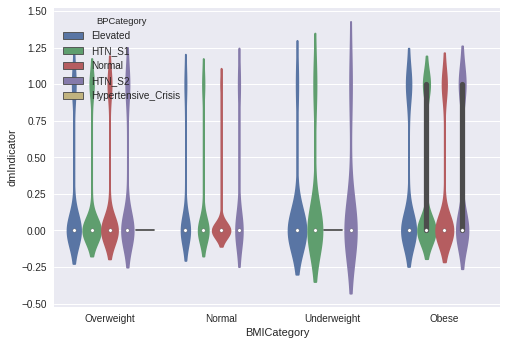

In [86]:

# # Show the survival proability as a function of age and sex
# g = sns.lmplot(x="age", y="survived", col="sex", hue="sex", data=df,
#                palette=pal, y_jitter=.02, logistic=True)
# g.set(xlim=(0, 80), ylim=(-.05, 1.05))

# Make a custom palette with gendered colors
# pal = dict(male="#6495ED", female="#F08080")


# # Show the survival proability as a function of age and sex
# g = sns.lmplot(x="BMICategory", y="dmIndicator",  data=X,
#                palette=pal, y_jitter=.02, logistic=True)
# g.set(xlim=(0, 80), ylim=(-.05, 1.05))


sns.violinplot(x="BMICategory", y="dmIndicator", hue="BPCategory", data=patients);
